### Setup Environment:

In [26]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.model import FoundationalCVModelWithClassifier, FoundationalCVModel
from src.FocalLoss import FocalLoss

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [27]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGES = os.path.join(DATASET, 'images/')
DOWNLOAD = False
SHAPE = (224, 224)
LABEL = 'DR_ICDR'
IMAGE_COL = 'image_id'
TEST_SIZE = 0.3
UNDERSAMPLE = False

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'retfound'
MODE = 'fine_tune'
backbone_mode='fine_tune'

HIDDEN = None #756
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 2

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 15
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [28]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [29]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))


Train data shape: (1208, 35)
Test data shape: (4880, 35)


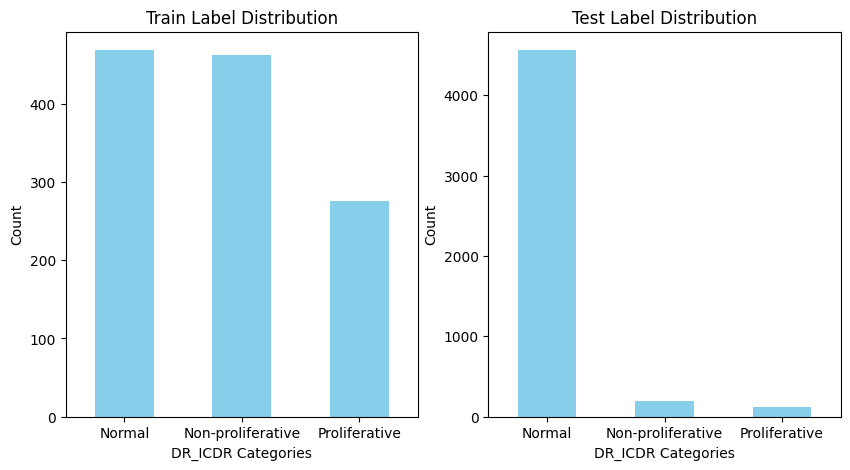

Getting validation set...
Train data shape: (4148, 35)
Test data shape: (732, 35)


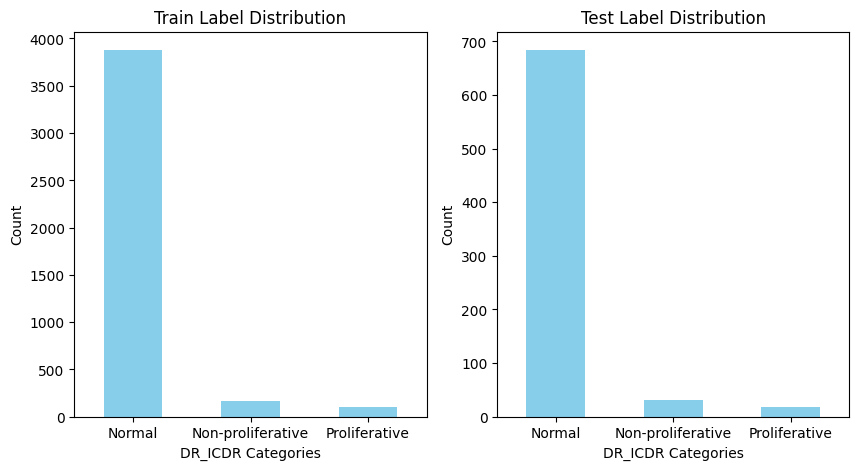

In [30]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=True, undersample_ratio=1.7)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.15)

### Dataloaders

In [31]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [32]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [33]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


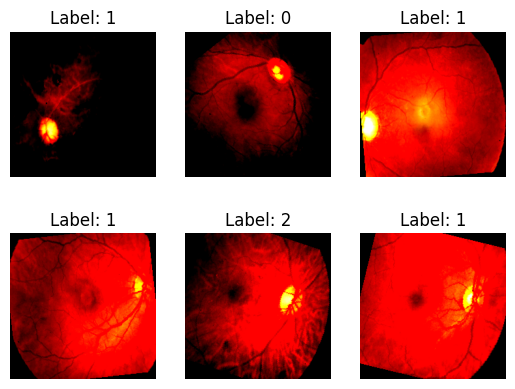

In [34]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [35]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE, weights='Weights/RETFound_cfp_weights.pth')
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [36]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [463 469 276]


100%|██████████| 76/76 [01:00<00:00,  1.25it/s]


Epoch 1, Training Loss: 0.3790747307633099


100%|██████████| 46/46 [00:25<00:00,  1.78it/s]


Epoch 1, Validation Loss: 0.4478610553171324, F1 Score: 0.1232071248005689


100%|██████████| 76/76 [01:00<00:00,  1.25it/s]


Epoch 2, Training Loss: 0.26645620578998014


100%|██████████| 46/46 [00:26<00:00,  1.77it/s]


Epoch 2, Validation Loss: 0.11280761084154896, F1 Score: 0.5506277571851342


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Epoch 3, Training Loss: 0.24943850954112254


100%|██████████| 46/46 [00:25<00:00,  1.83it/s]


Epoch 3, Validation Loss: 0.14293759121843005, F1 Score: 0.49981481481481477


100%|██████████| 76/76 [01:01<00:00,  1.25it/s]


Epoch 4, Training Loss: 0.2131193870384442


100%|██████████| 46/46 [00:24<00:00,  1.85it/s]


Epoch 4, Validation Loss: 0.1792303419307522, F1 Score: 0.47384894580155784


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Epoch 5, Training Loss: 0.2031633386290387


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]


Epoch 5, Validation Loss: 0.14442661955304767, F1 Score: 0.503545337382311


100%|██████████| 76/76 [01:00<00:00,  1.25it/s]


Epoch 6, Training Loss: 0.19588620764644524


100%|██████████| 46/46 [00:25<00:00,  1.83it/s]


Epoch 6, Validation Loss: 0.27383608565382334, F1 Score: 0.39116176137452735


100%|██████████| 76/76 [01:01<00:00,  1.24it/s]


Epoch 7, Training Loss: 0.18344572446260013


100%|██████████| 46/46 [00:25<00:00,  1.83it/s]


Epoch 7, Validation Loss: 0.1252477867933719, F1 Score: 0.5525089665526733


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Epoch 8, Training Loss: 0.16626772387443403


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]


Epoch 8, Validation Loss: 0.17430899713350378, F1 Score: 0.4936453654632265


100%|██████████| 76/76 [01:01<00:00,  1.24it/s]


Epoch 9, Training Loss: 0.16018954556631415


100%|██████████| 46/46 [00:25<00:00,  1.78it/s]


Epoch 9, Validation Loss: 0.11190482876870943, F1 Score: 0.5557897215365428


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Epoch 10, Training Loss: 0.15817622487482272


100%|██████████| 46/46 [00:25<00:00,  1.79it/s]


Epoch 10, Validation Loss: 0.06083411314403233, F1 Score: 0.6172180415103731


100%|██████████| 76/76 [01:00<00:00,  1.25it/s]


Epoch 11, Training Loss: 0.16422825355670953


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]


Epoch 11, Validation Loss: 0.11397664961607559, F1 Score: 0.5096827365732162


100%|██████████| 76/76 [01:01<00:00,  1.24it/s]


Epoch 12, Training Loss: 0.15154453327781275


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]


Epoch 12, Validation Loss: 0.08058314495112585, F1 Score: 0.5866958192539588


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Epoch 13, Training Loss: 0.1376320818733228


100%|██████████| 46/46 [00:24<00:00,  1.84it/s]


Epoch 13, Validation Loss: 0.11188660351478535, F1 Score: 0.5919665995302132


100%|██████████| 76/76 [01:01<00:00,  1.24it/s]


Epoch 14, Training Loss: 0.13423180697779907


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]


Epoch 14, Validation Loss: 0.06290800743938788, F1 Score: 0.6489852231679795


100%|██████████| 76/76 [01:00<00:00,  1.25it/s]


Epoch 15, Training Loss: 0.1395649278144303


100%|██████████| 46/46 [00:24<00:00,  1.84it/s]


Epoch 15, Validation Loss: 0.04705115247760778, F1 Score: 0.6396175024053109


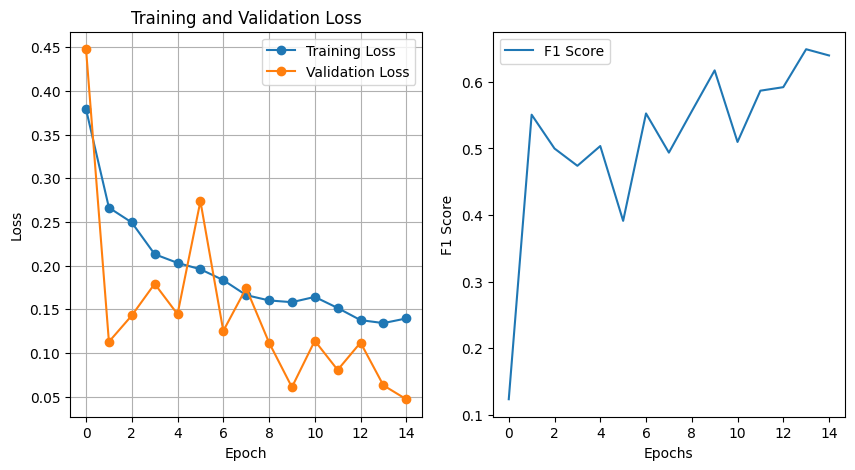

Training finished.


In [37]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

100%|██████████| 260/260 [02:19<00:00,  1.87it/s]


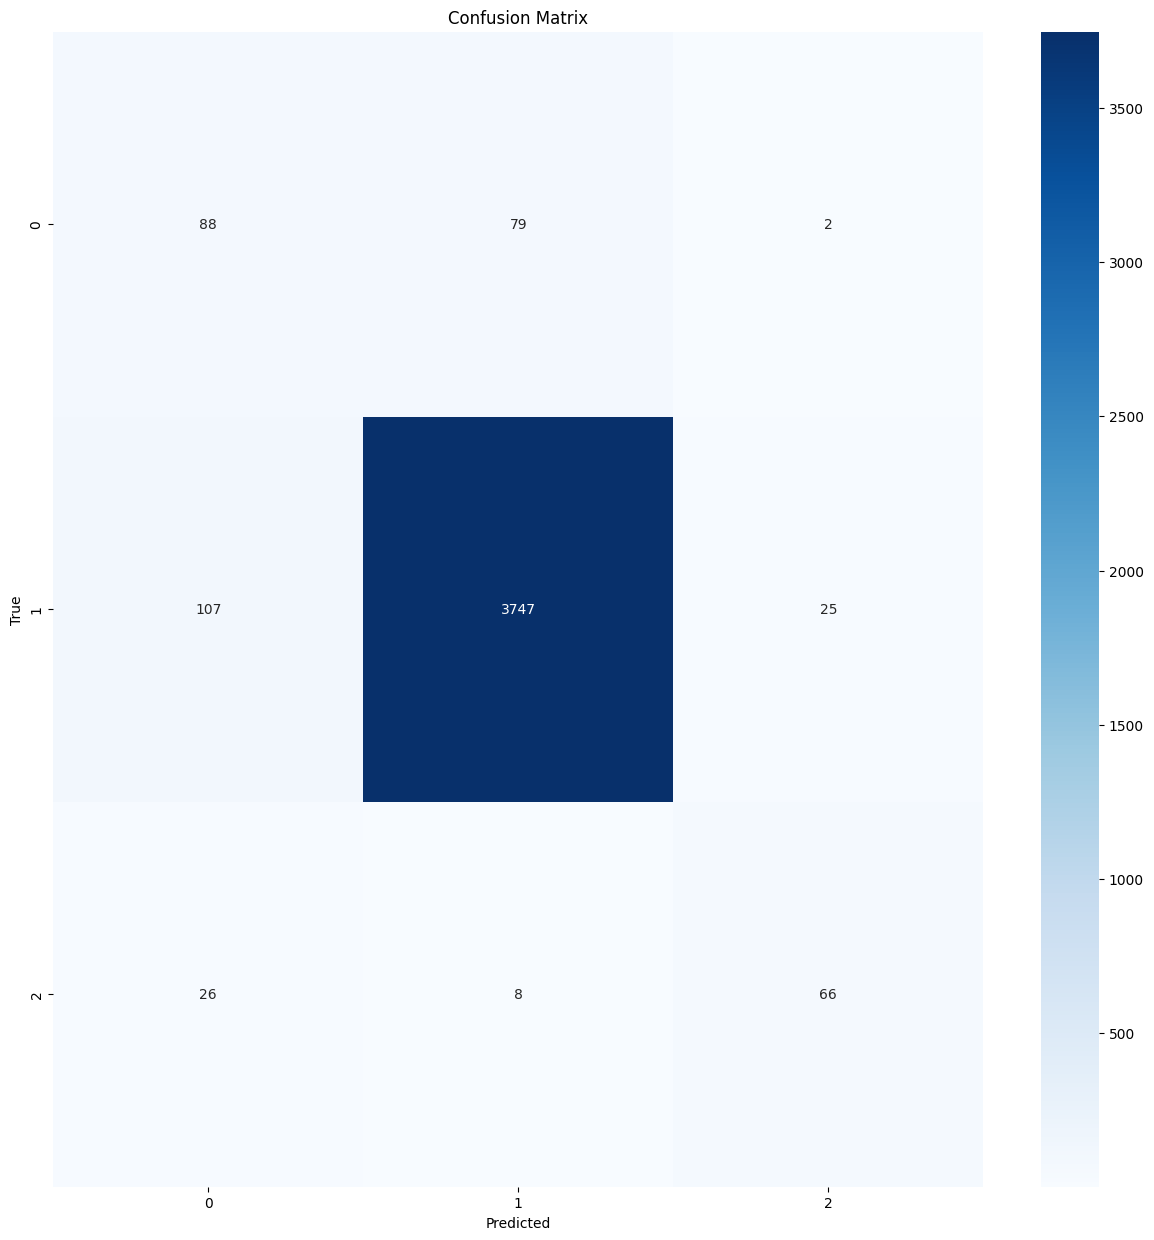

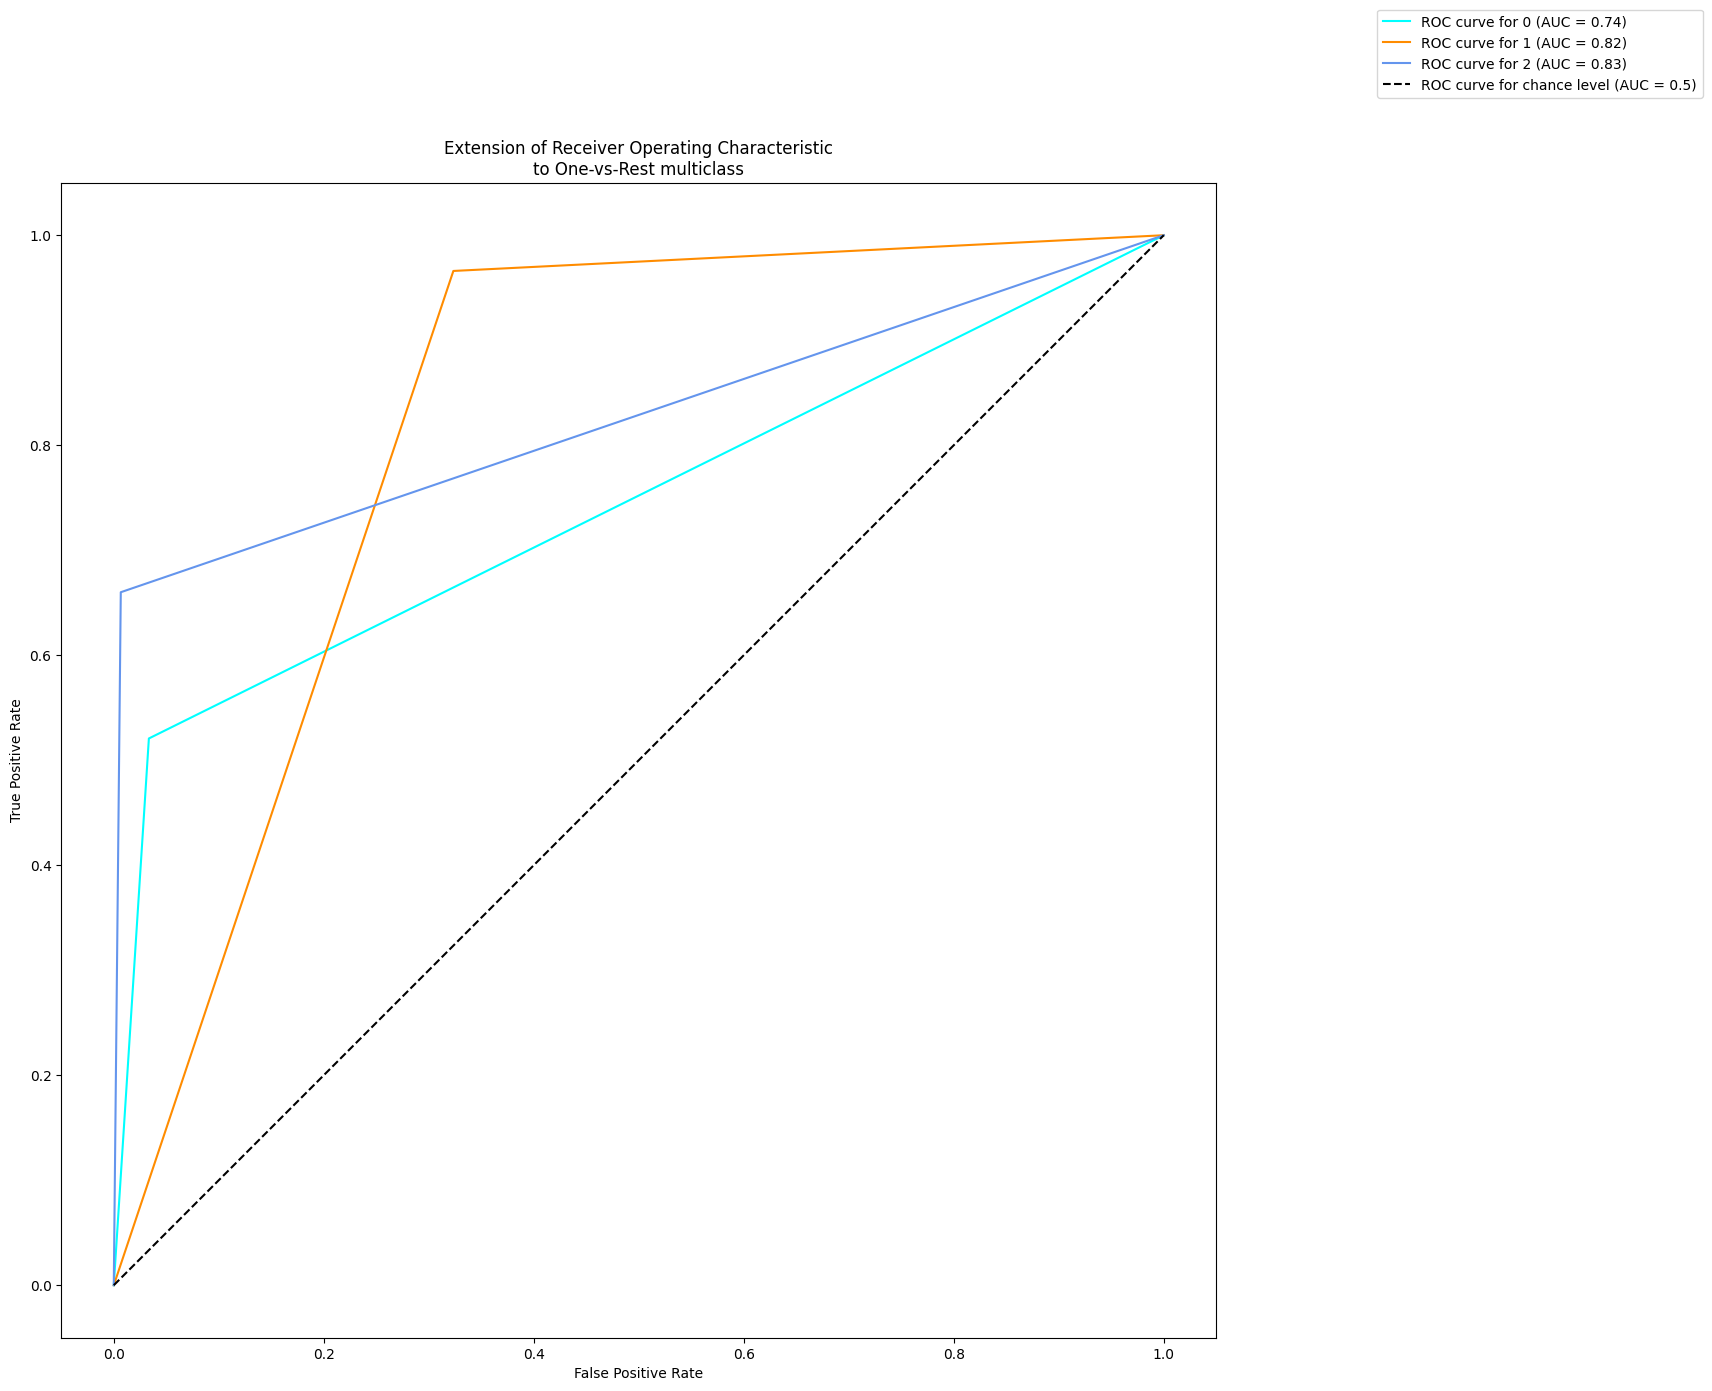

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.40      0.52      0.45       169
           1       0.98      0.97      0.97      3879
           2       0.71      0.66      0.68       100

    accuracy                           0.94      4148
   macro avg       0.70      0.72      0.70      4148
weighted avg       0.95      0.94      0.94      4148

##################################################  Saliency Maps  ##################################################

Class 0:


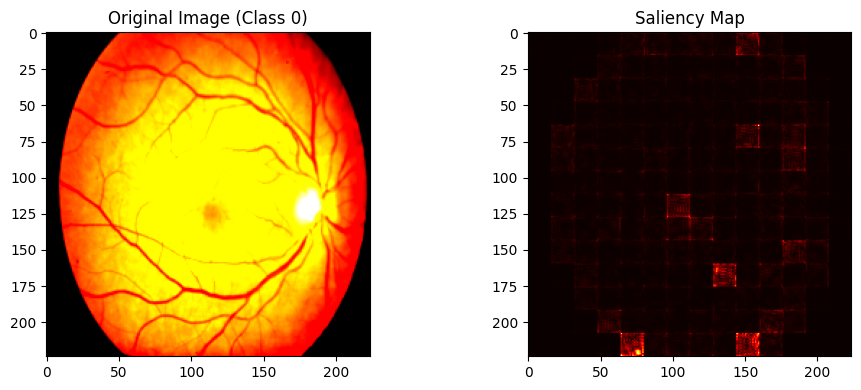

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


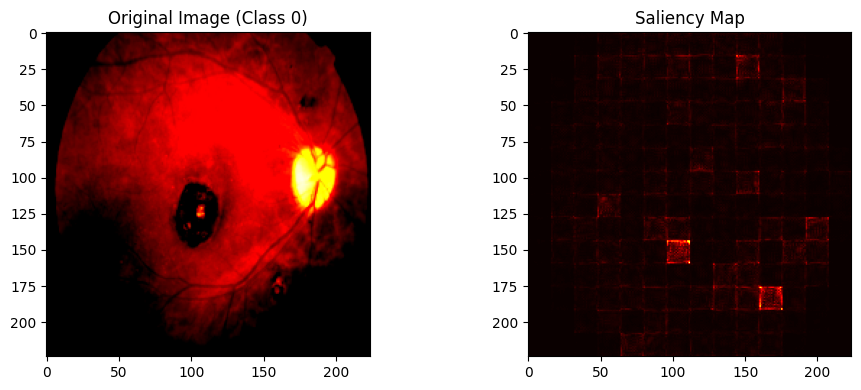

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


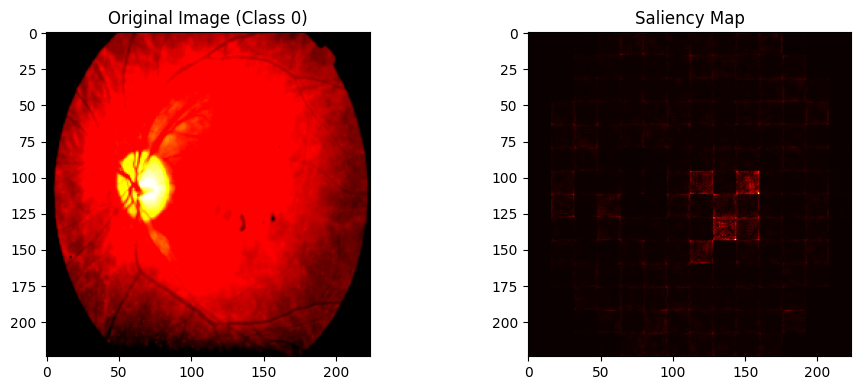

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


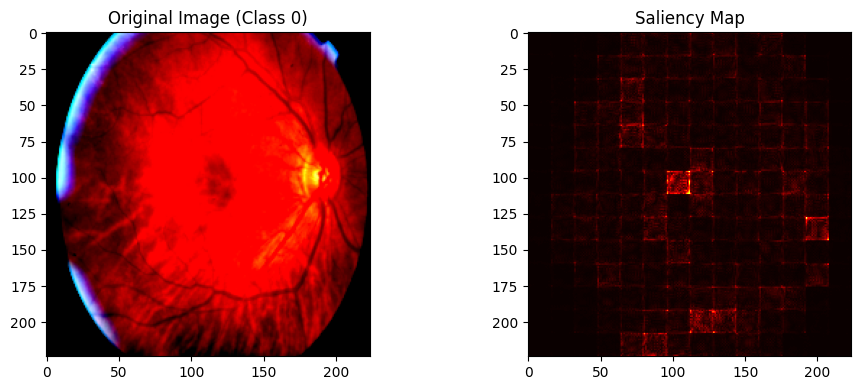

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


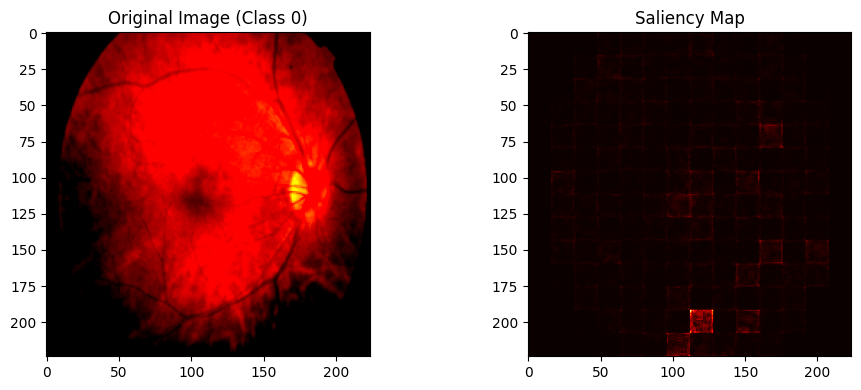

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


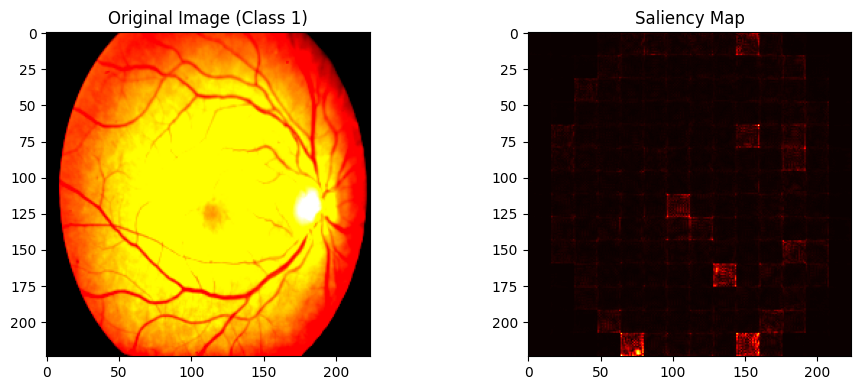

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


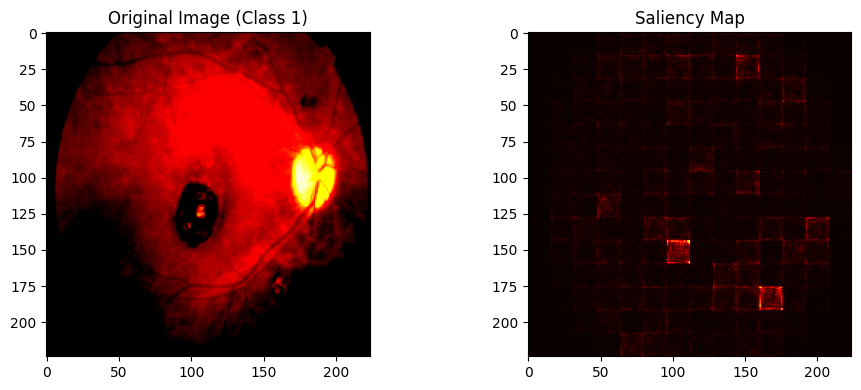

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


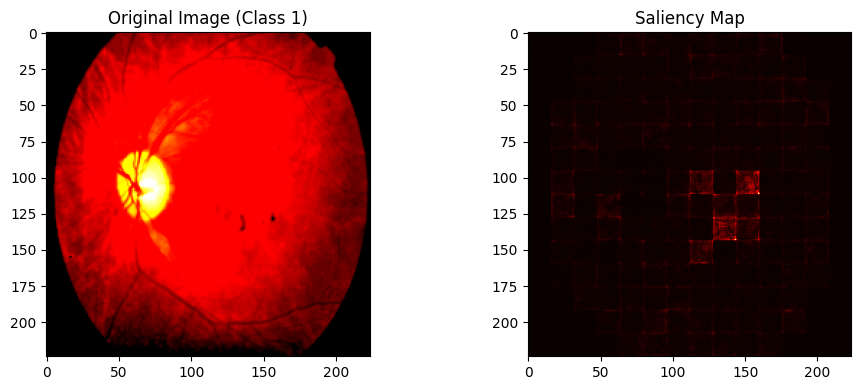

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


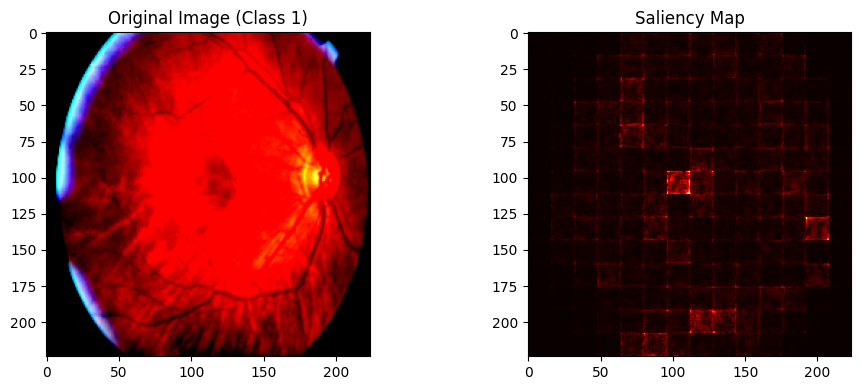

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


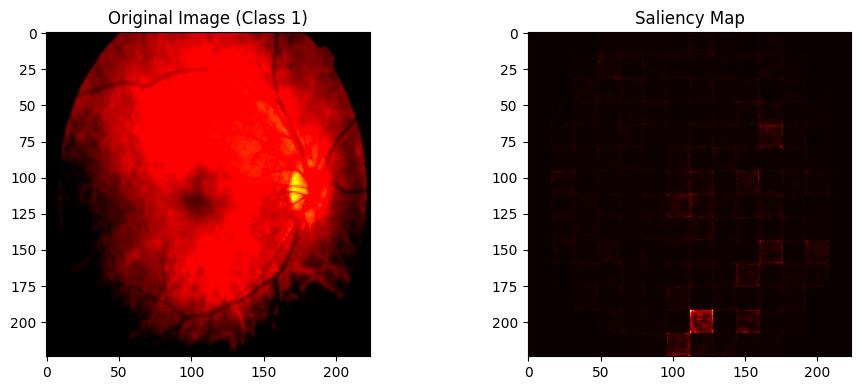

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


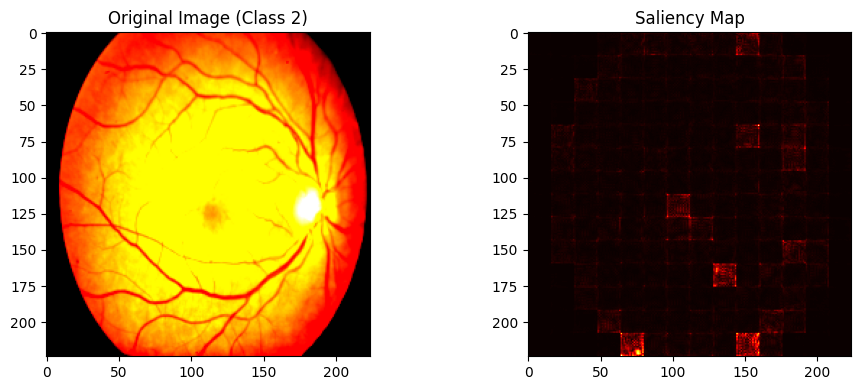

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


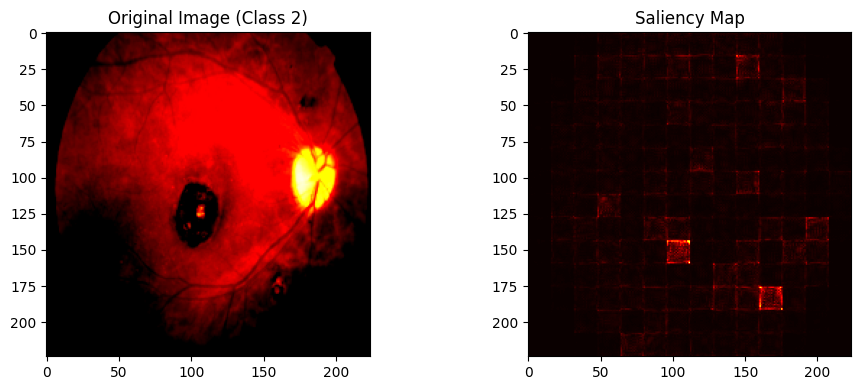

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


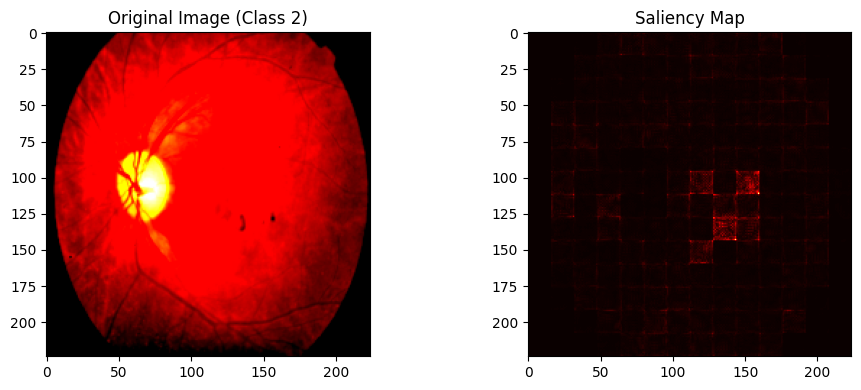

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


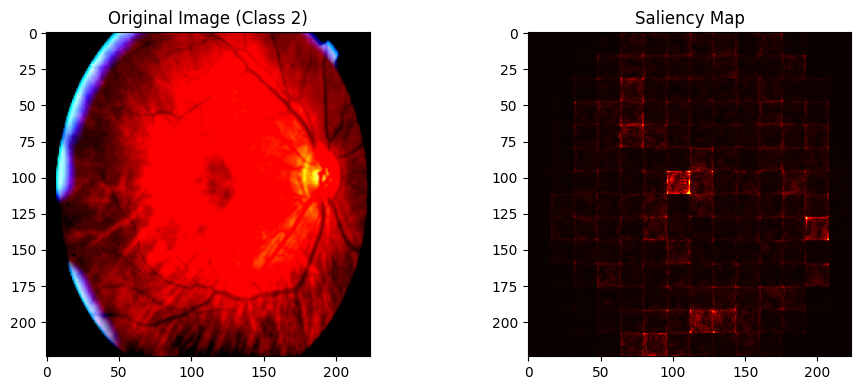

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


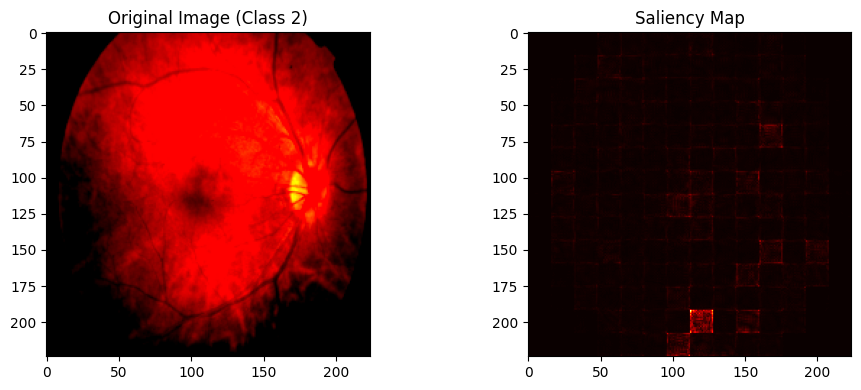

In [38]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [39]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 229/229 [02:01<00:00,  1.89it/s]


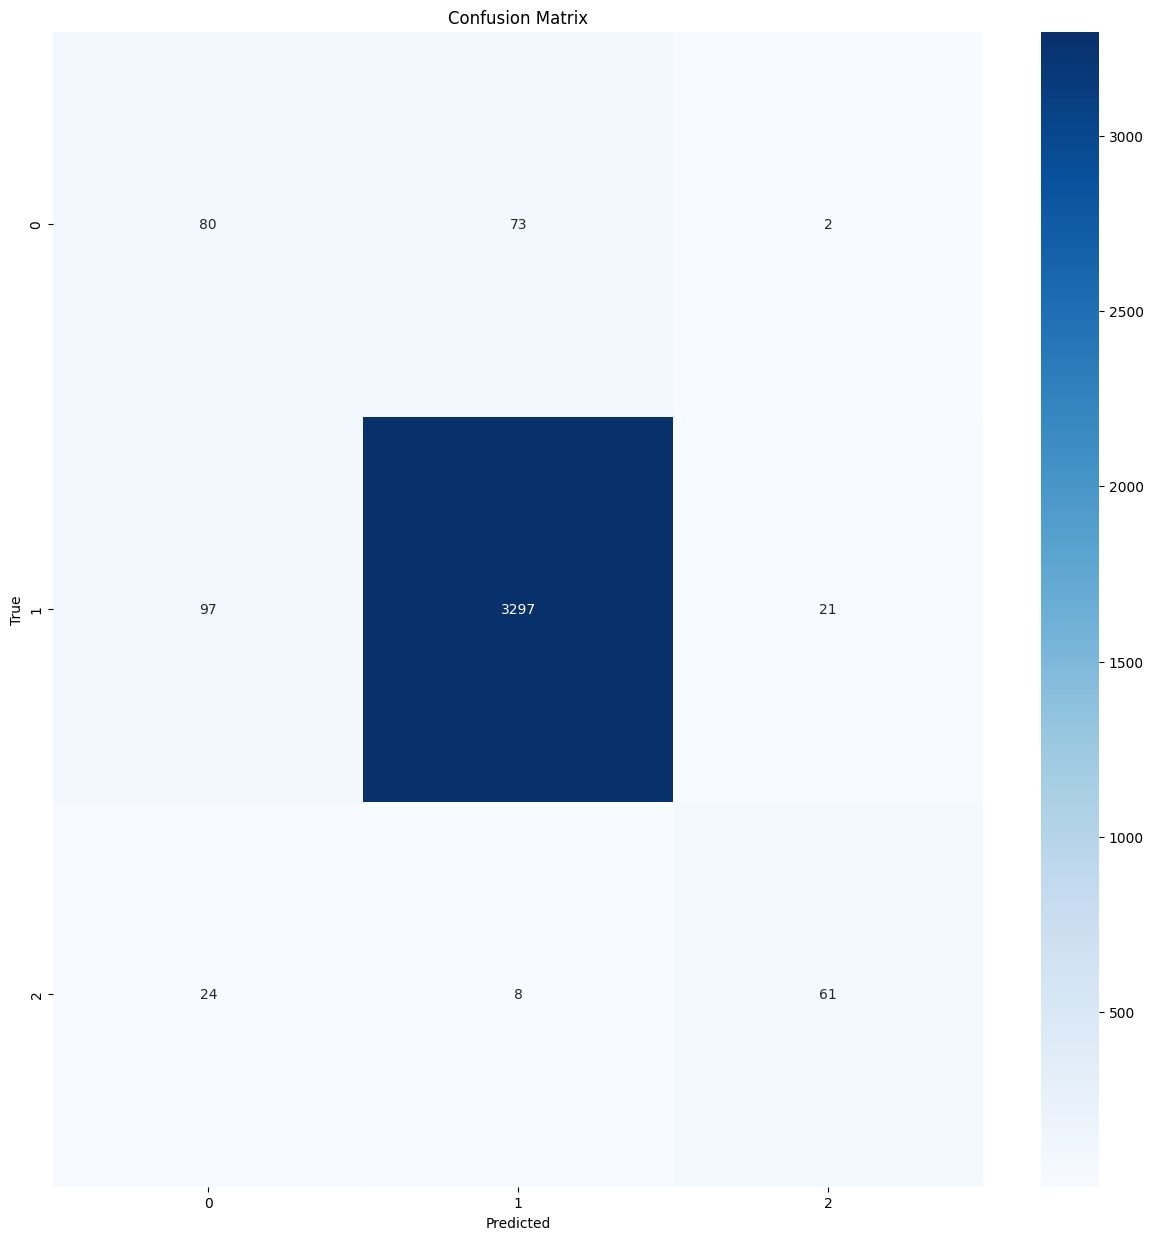

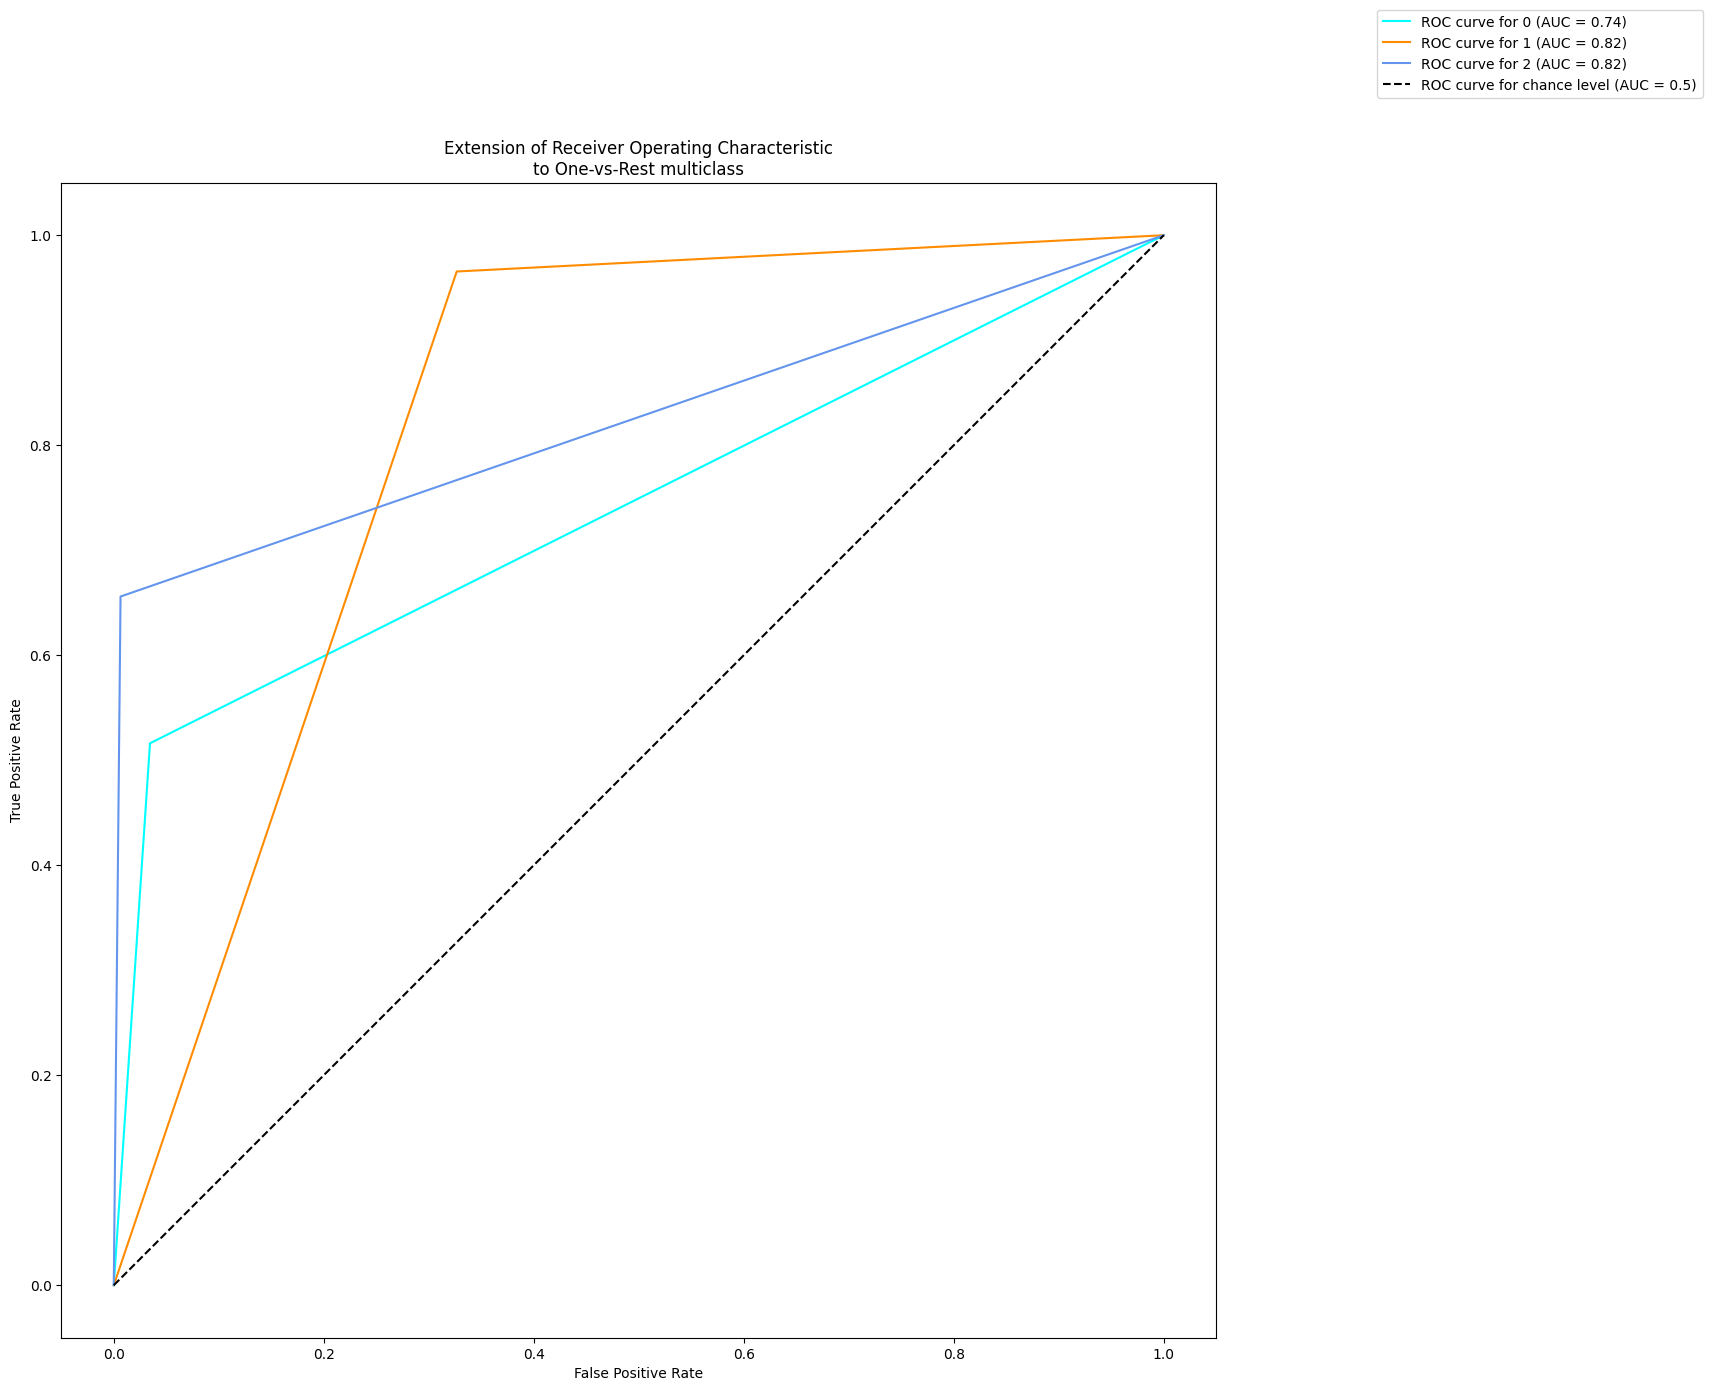

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.40      0.52      0.45       155
           1       0.98      0.97      0.97      3415
           2       0.73      0.66      0.69        93

    accuracy                           0.94      3663
   macro avg       0.70      0.71      0.70      3663
weighted avg       0.95      0.94      0.94      3663

##################################################  Saliency Maps  ##################################################

Class 0:


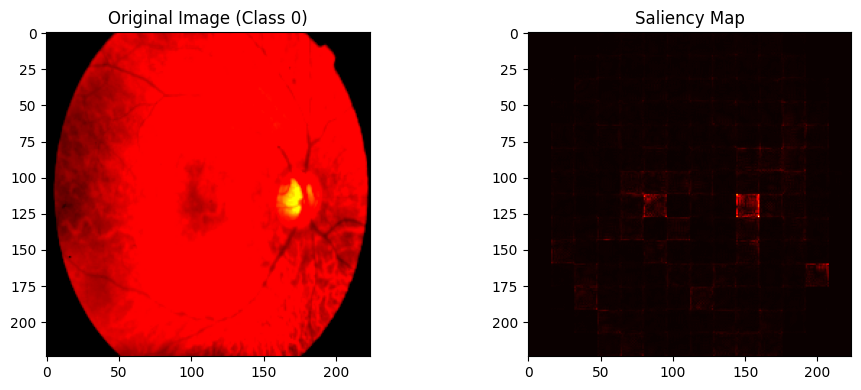

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


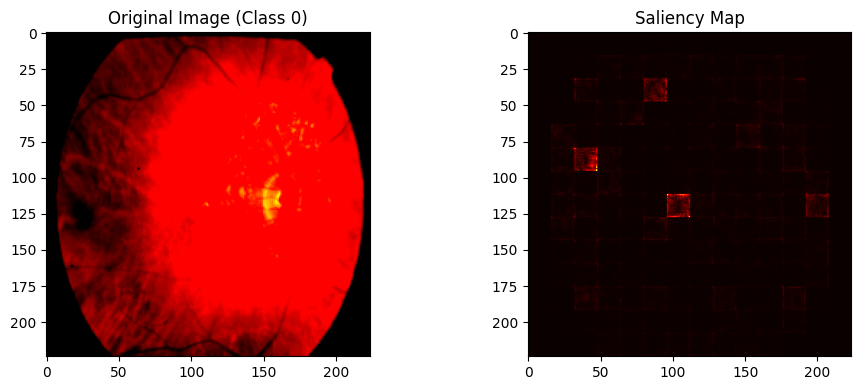

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


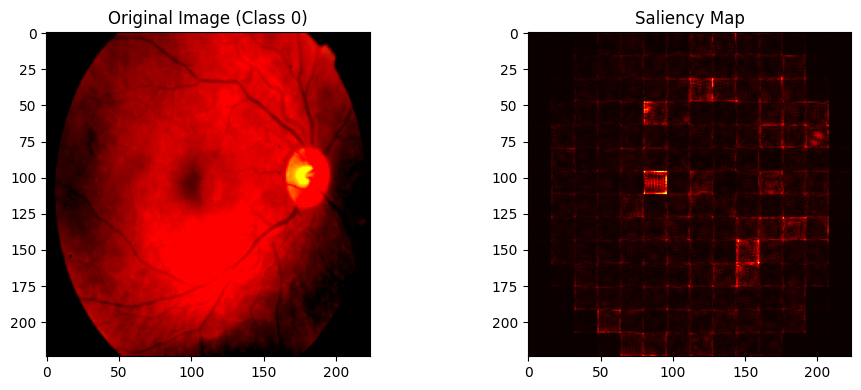

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


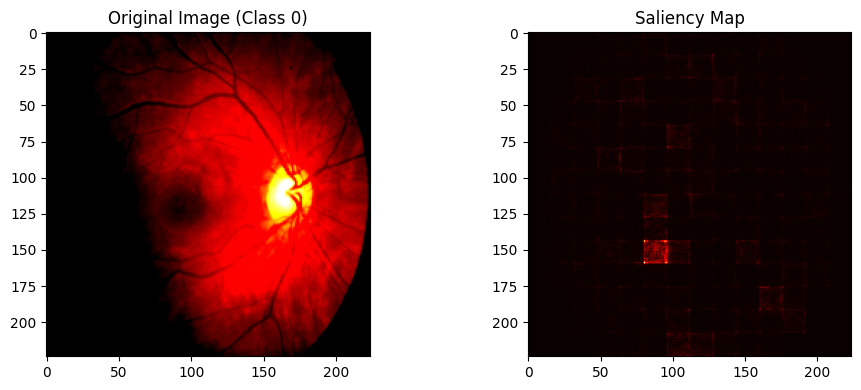

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


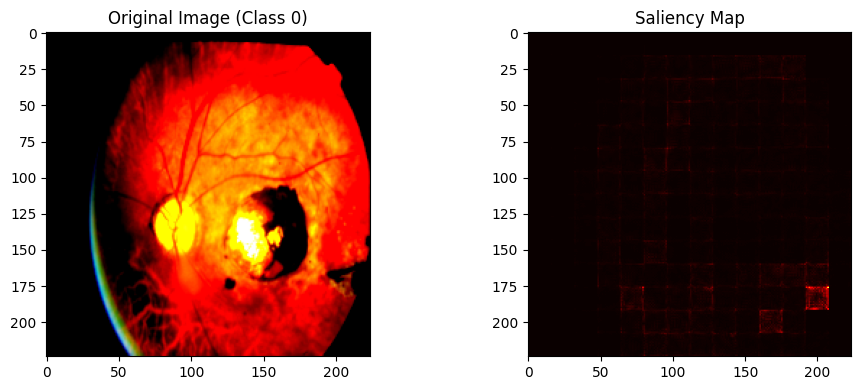

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


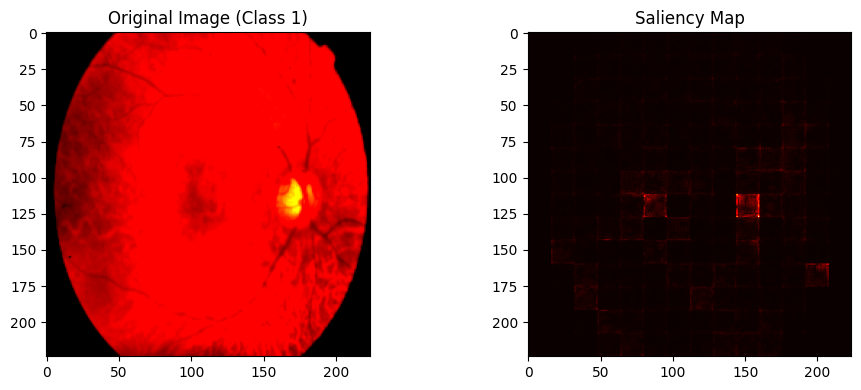

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


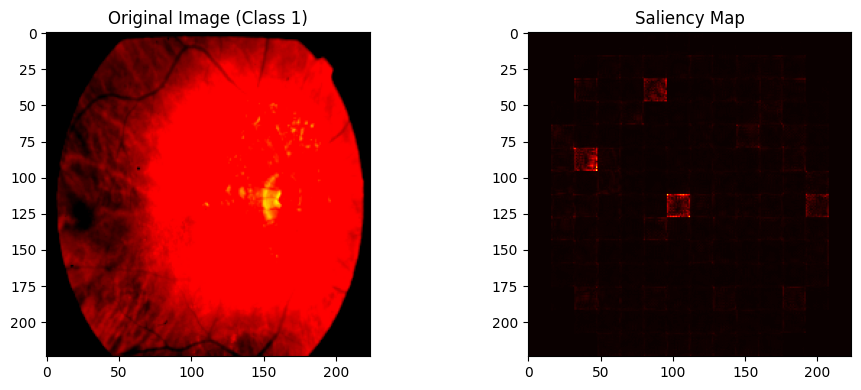

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


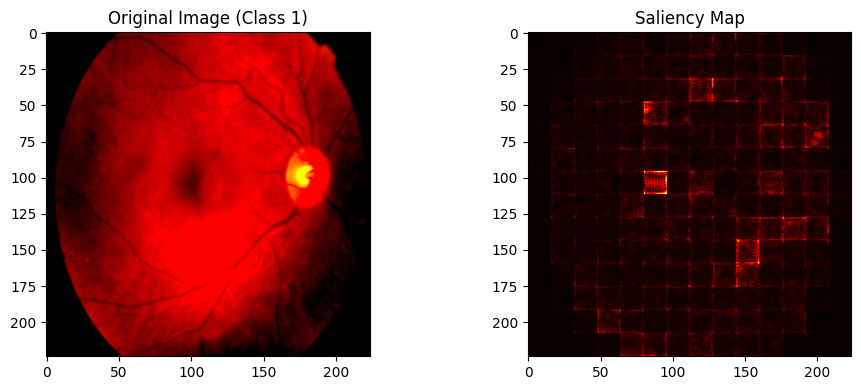

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


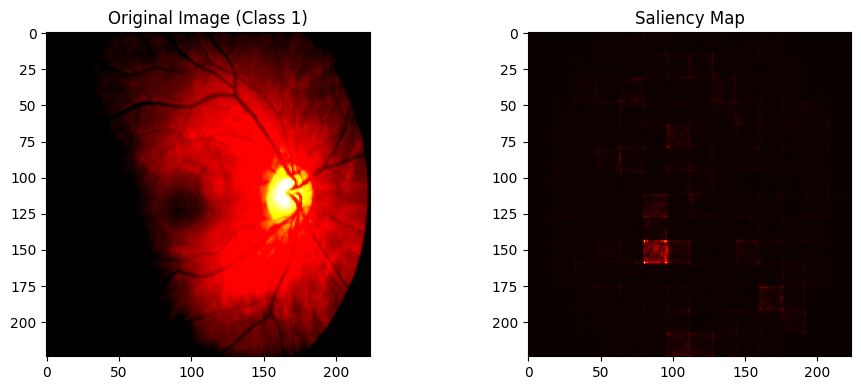

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


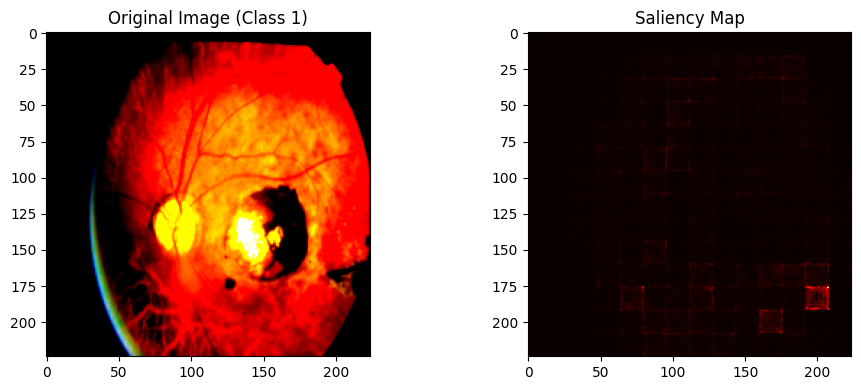

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


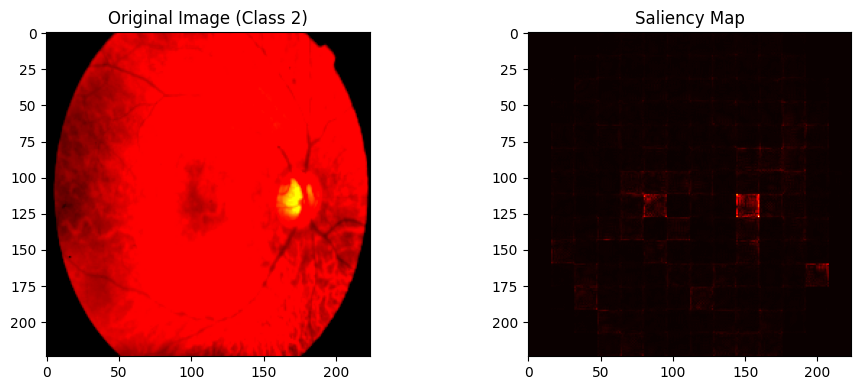

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


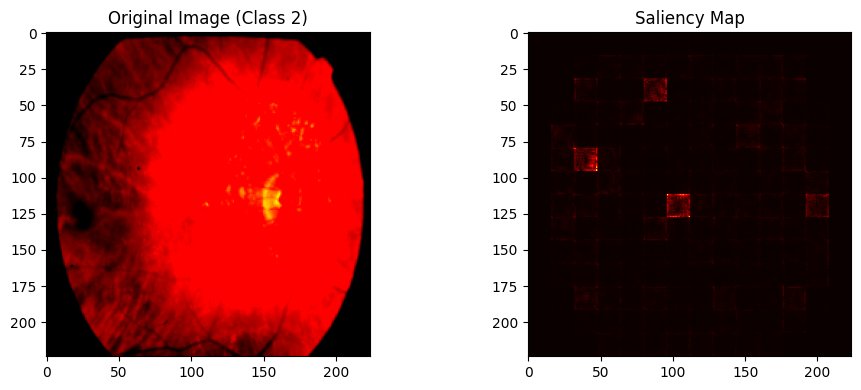

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


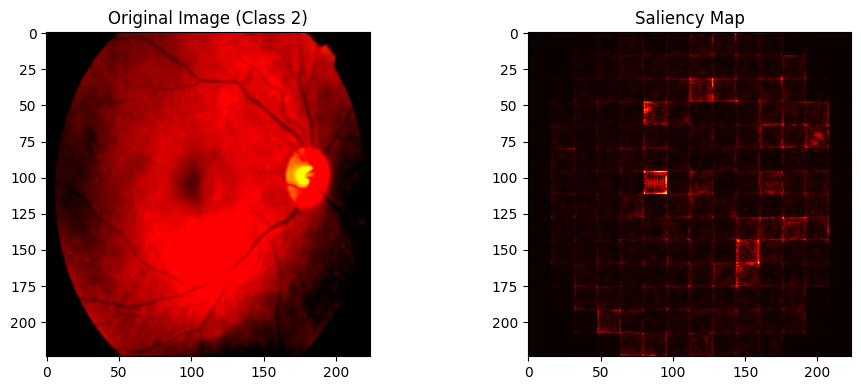

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


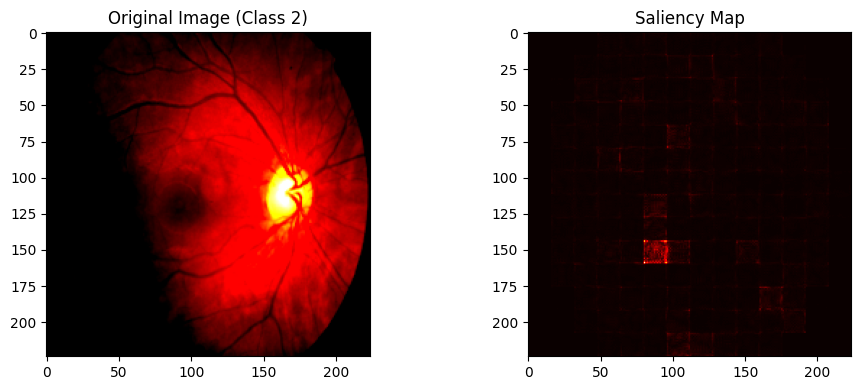

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


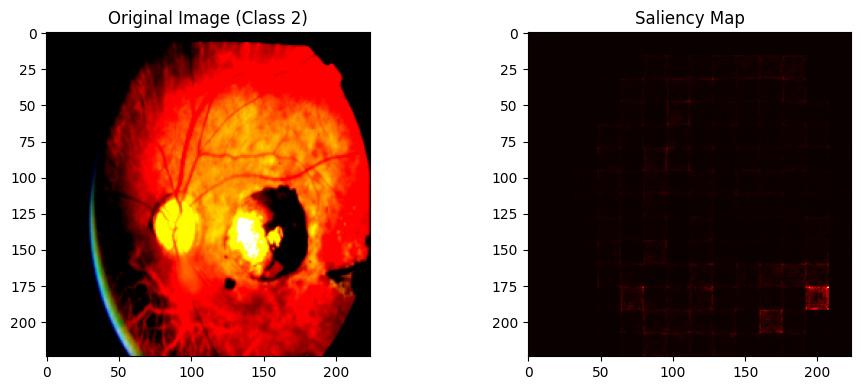

In [40]:
test(model, adequate_dataloader, saliency=True, device=device)

#### Inadequate image quality

100%|██████████| 31/31 [00:17<00:00,  1.74it/s]


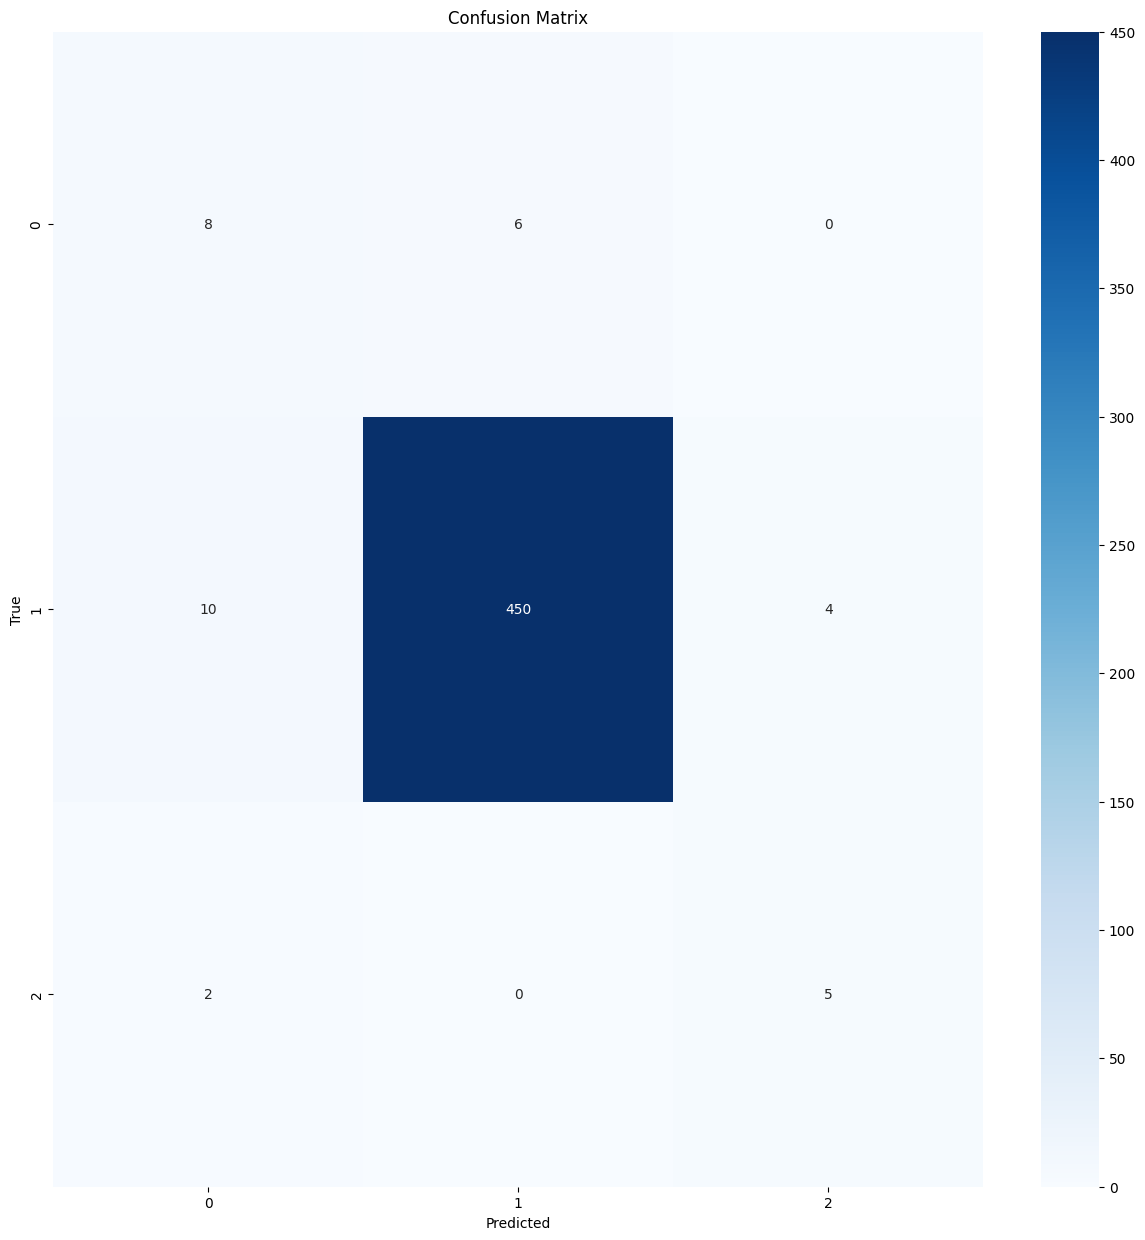

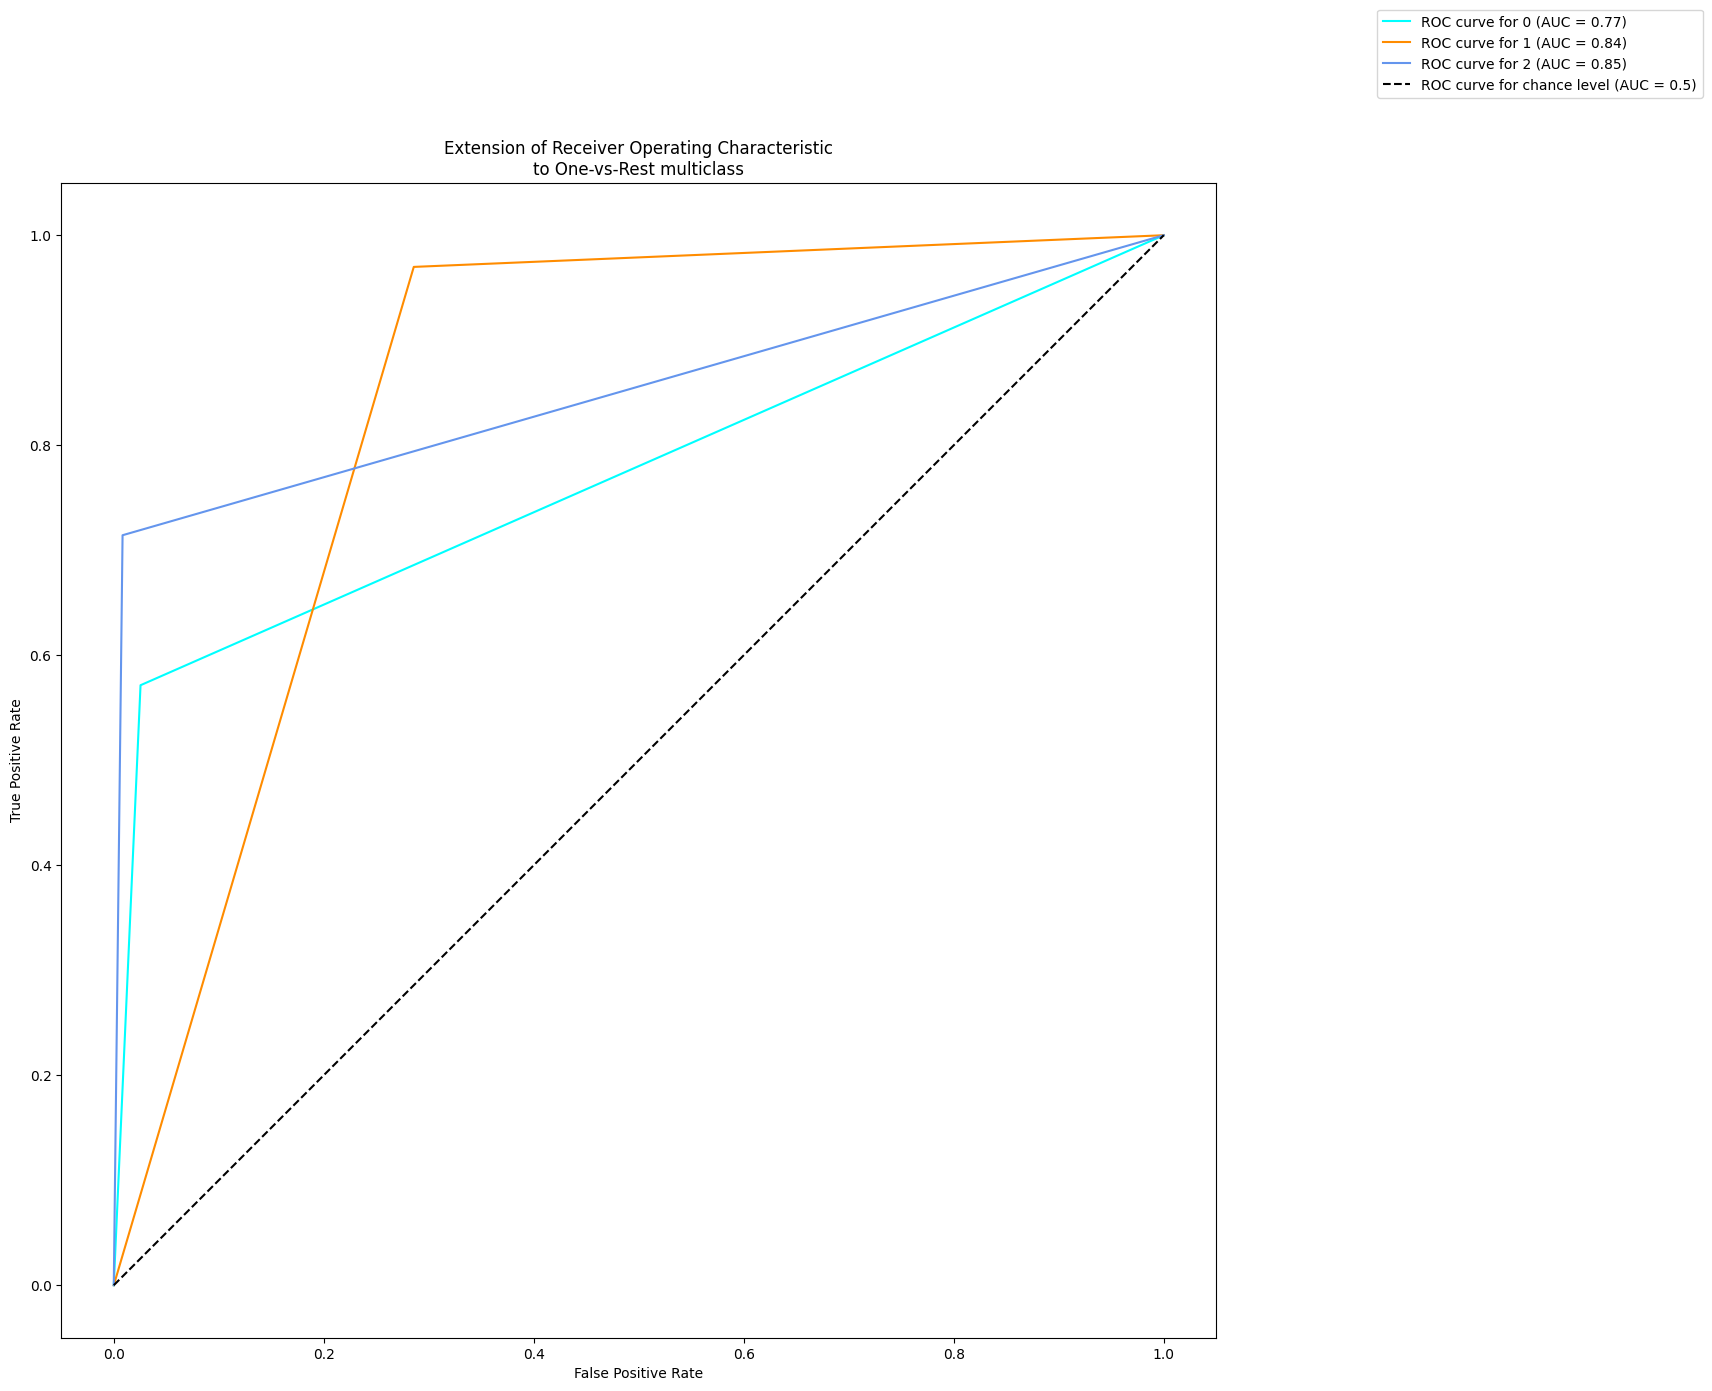

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.40      0.57      0.47        14
           1       0.99      0.97      0.98       464
           2       0.56      0.71      0.63         7

    accuracy                           0.95       485
   macro avg       0.65      0.75      0.69       485
weighted avg       0.96      0.95      0.96       485

##################################################  Saliency Maps  ##################################################

Class 0:


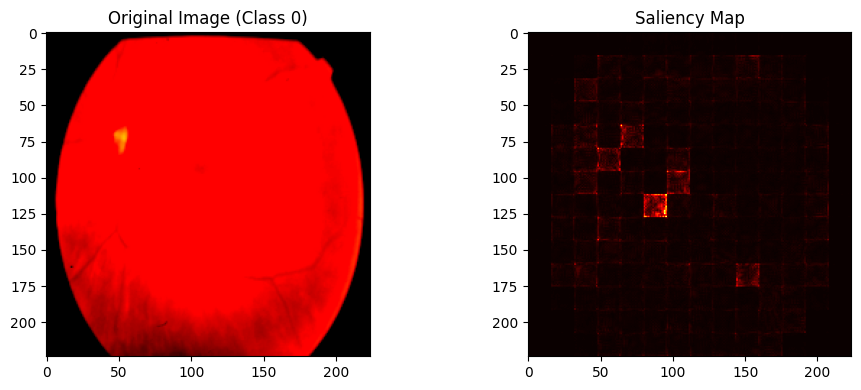

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


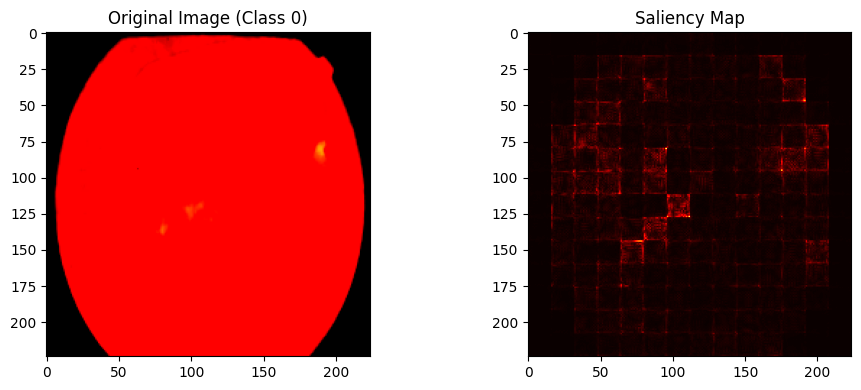

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


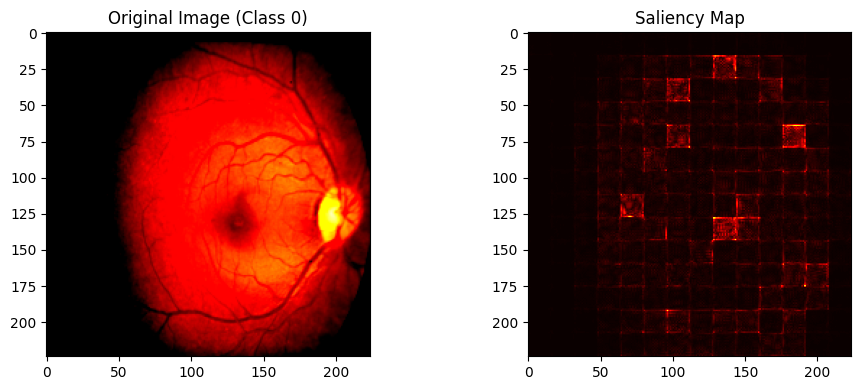

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


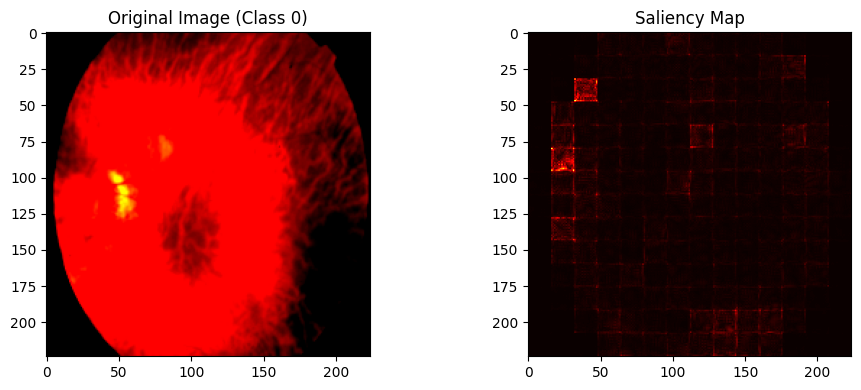

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


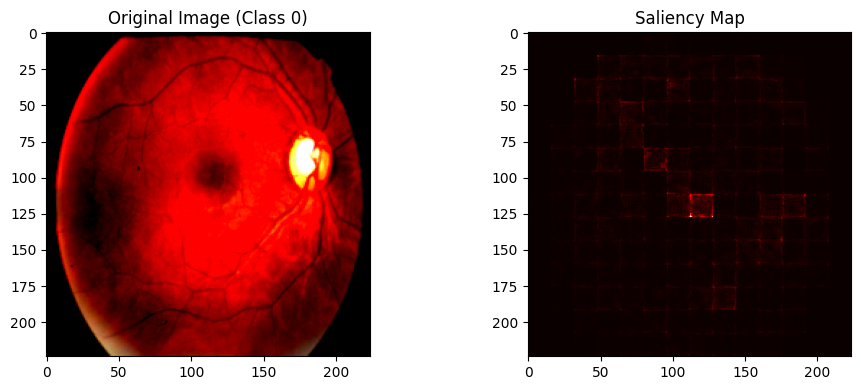

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


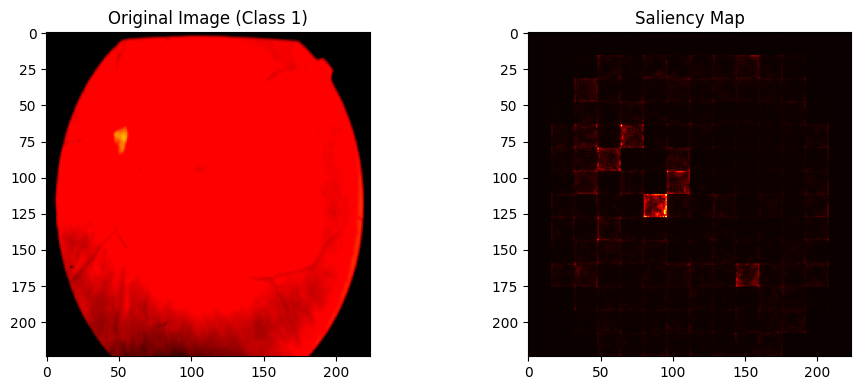

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


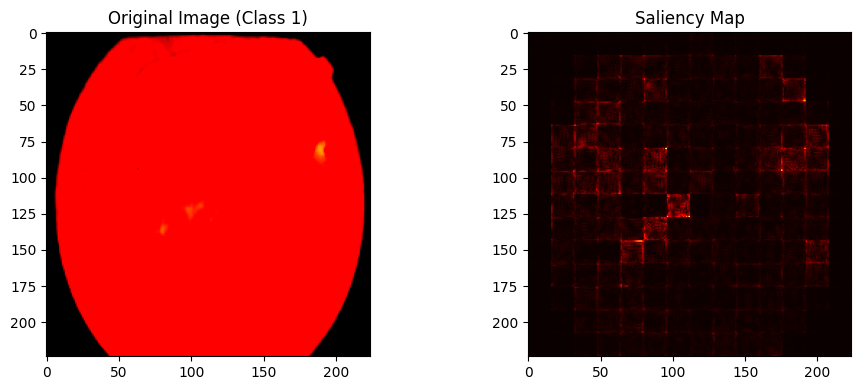

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


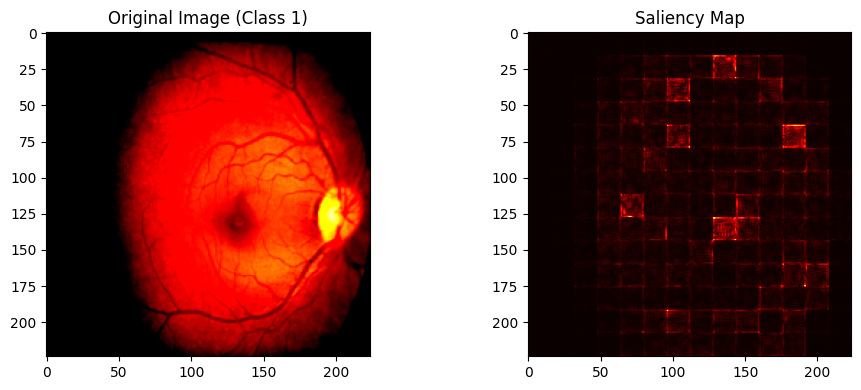

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


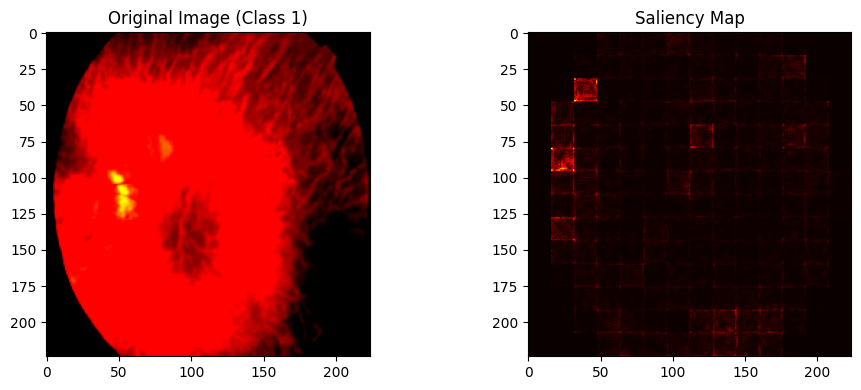

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


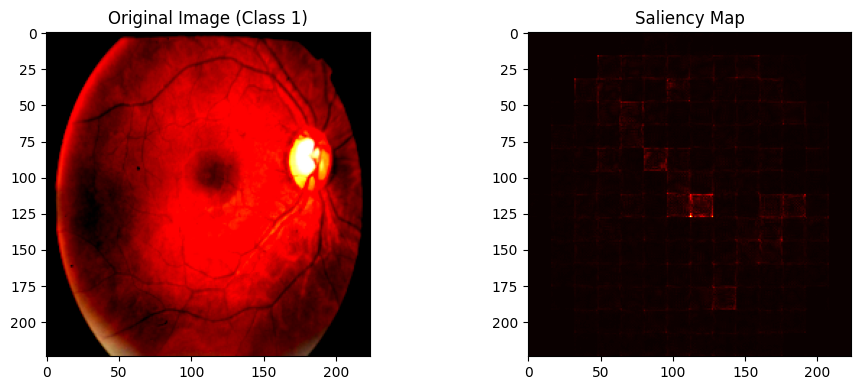

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


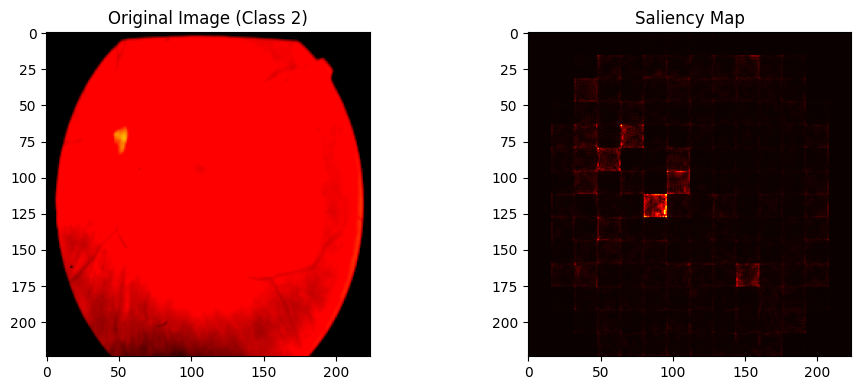

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


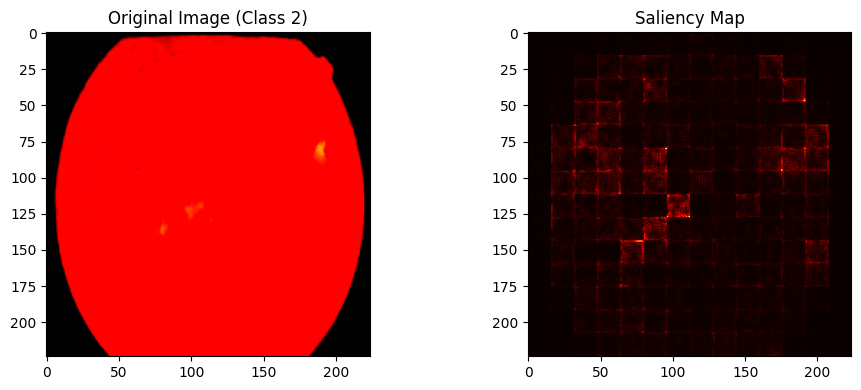

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


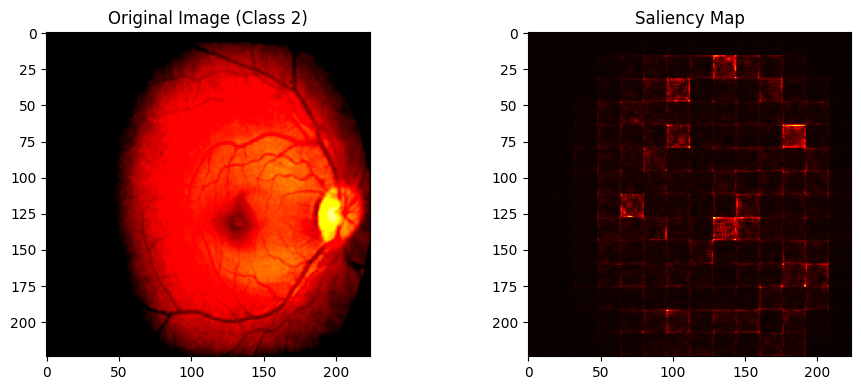

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


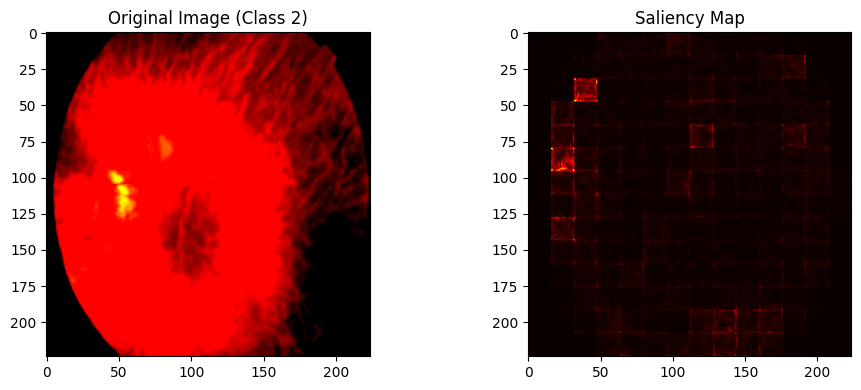

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


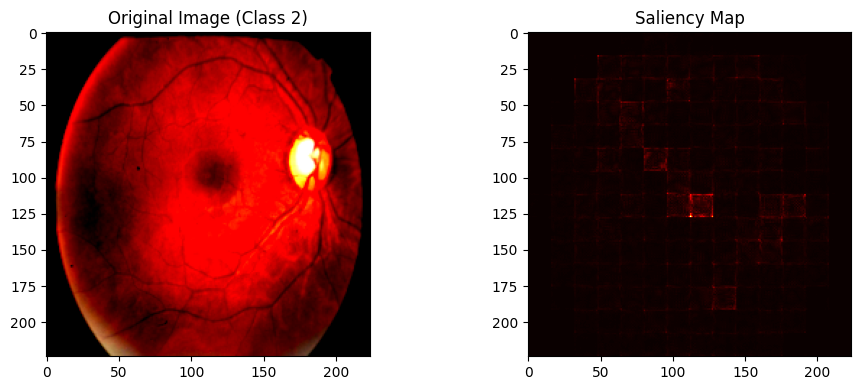

In [41]:
test(model, inadequate_dataloader, saliency=True, device=device)